# Health Monitor — Analysis

Correlate self-reported events (food, stress, mood) with Garmin biometrics (sleep, HR, stress score) to find triggers for skin inflammation.

**Data sources**
- `data/health.db → events` — manually logged via `hm` CLI
- `data/health.db → garmin_daily` — synced from GarminDB via `scripts/garmin_sync.py`

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

DB = Path('..') / 'data' / 'health.db'

def q(sql, **kwargs):
    with sqlite3.connect(DB) as conn:
        return pd.read_sql_query(sql, conn, **kwargs)

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
print('Connected to', DB.resolve())

Connected to /Users/oskarlindenau/Desktop/CS/health_monitor/data/health.db


## 1. What's in the database?

In [2]:
events = q("SELECT * FROM events ORDER BY timestamp DESC")
events['date'] = pd.to_datetime(events['timestamp']).dt.date
print(f"{len(events)} events across {events['date'].nunique()} days")
events.head(10)

3 events across 1 days


,id,timestamp,tag,category,value,notes,source,date
0,3,2026-02-18T18:41:23.977788+00:00,symptom,face_redness,6,after breakfast,cli,2026-02-18
1,2,2026-02-18T18:41:23.915352+00:00,food,junk,alcohol,None,cli,2026-02-18
2,1,2026-02-18T18:41:23.852818+00:00,food,regular,avocado,None,cli,2026-02-18


In [3]:
garmin = q("SELECT * FROM garmin_daily ORDER BY day DESC")
garmin['day'] = pd.to_datetime(garmin['day'])
garmin['sleep_h'] = garmin['sleep_total_sec'] / 3600
garmin['rem_h']   = garmin['sleep_rem_sec']   / 3600
print(f"{len(garmin)} days of Garmin data")
garmin.head()

79 days of Garmin data


,day,steps,rhr_avg,hr_avg,stress_avg,sleep_total_sec,sleep_rem_sec,calories_active,synced_at,sleep_h,rem_h
0,2026-02-17,None,None,None,None,0,0,None,2026-02-19T06:41:14.078804+00:00,0.0,0.0
1,2026-02-16,None,None,None,None,0,0,None,2026-02-19T06:41:14.078804+00:00,0.0,0.0
2,2026-02-15,None,None,None,None,0,0,None,2026-02-19T06:41:14.078804+00:00,0.0,0.0
3,2026-02-14,None,None,None,None,0,0,None,2026-02-19T06:41:14.078804+00:00,0.0,0.0
4,2026-02-13,None,None,None,None,0,0,None,2026-02-19T06:41:14.078804+00:00,0.0,0.0


## 2. Symptom timeline

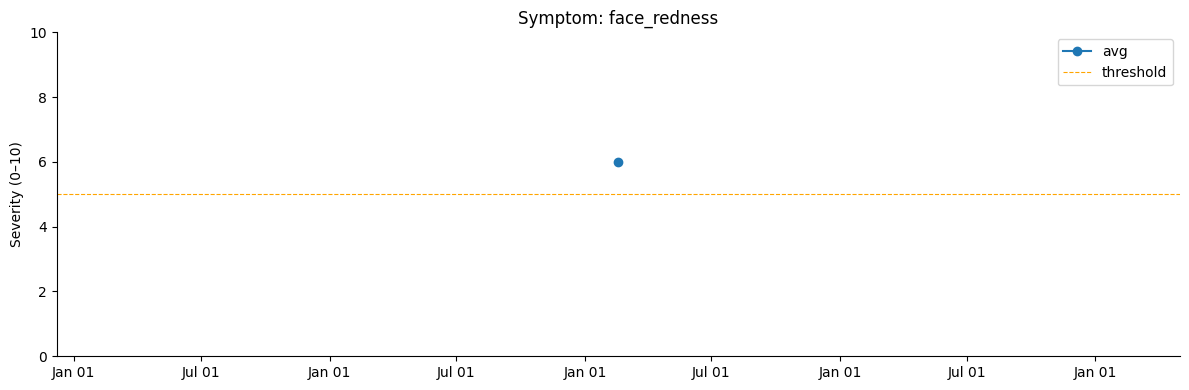

In [4]:
symptoms = q("""
    SELECT
        date(timestamp)        AS day,
        category               AS symptom,
        AVG(CAST(value AS REAL)) AS avg_score,
        MAX(CAST(value AS REAL)) AS max_score
    FROM events
    WHERE tag = 'symptom'
    GROUP BY date(timestamp), category
    ORDER BY day
""")
symptoms['day'] = pd.to_datetime(symptoms['day'])

for name, grp in symptoms.groupby('symptom'):
    fig, ax = plt.subplots()
    ax.plot(grp['day'], grp['avg_score'], marker='o', label='avg')
    ax.fill_between(grp['day'], 0, grp['avg_score'], alpha=0.15)
    ax.set_ylim(0, 10)
    ax.set_ylabel('Severity (0–10)')
    ax.set_title(f'Symptom: {name}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.axhline(5, color='orange', linewidth=0.8, linestyle='--', label='threshold')
    ax.legend()
    plt.tight_layout()
    plt.show()

if symptoms.empty:
    print('No symptom data yet. Log with: hm symptom face_redness 6')

## 3. Symptom vs. Garmin biometrics

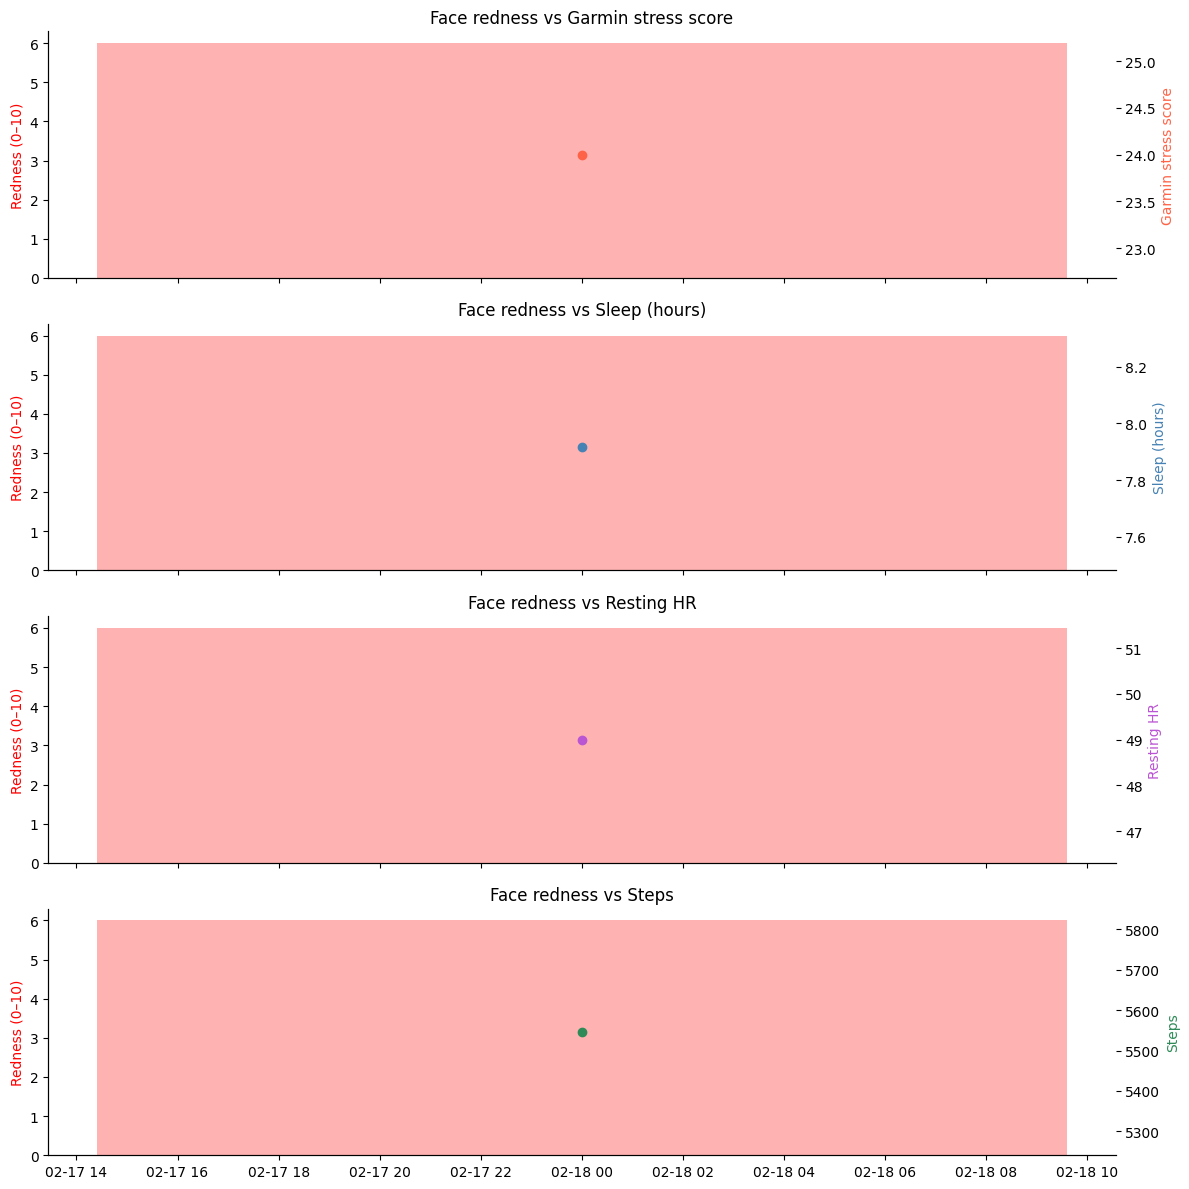

In [3]:
df = q("""
    SELECT
        date(e.timestamp)            AS day,
        AVG(CAST(e.value AS REAL))   AS redness,
        g.stress_avg,
        g.rhr_avg,
        g.steps,
        g.sleep_total_sec / 3600.0   AS sleep_h
    FROM events e
    LEFT JOIN garmin_daily g ON date(e.timestamp) = g.day
    WHERE e.tag = 'symptom' AND e.category = 'face_redness'
    GROUP BY date(e.timestamp)
    ORDER BY day
""")
df['day'] = pd.to_datetime(df['day'])

metrics = {
    'stress_avg': ('Garmin stress score', 'tomato'),
    'sleep_h':    ('Sleep (hours)',        'steelblue'),
    'rhr_avg':    ('Resting HR',           'mediumorchid'),
    'steps':      ('Steps',                'seagreen'),
}

available = [m for m in metrics if df[m].notna().any()]

if df.empty or df['redness'].isna().all():
    print('No face_redness data yet.')
elif not available:
    print('Garmin biometric data not yet synced. Run:\n  python scripts/garmin_sync.py')
    print('\nRedness data available:')
    print(df[['day', 'redness']])
else:
    fig, axes = plt.subplots(len(available), 1, figsize=(12, 3 * len(available)), sharex=True)
    if len(available) == 1:
        axes = [axes]
    for ax, metric in zip(axes, available):
        label, color = metrics[metric]
        ax2 = ax.twinx()
        ax.bar(df['day'], df['redness'], alpha=0.3, color='red', label='redness')
        ax2.plot(df['day'], df[metric], color=color, marker='o', label=label)
        ax.set_ylabel('Redness (0–10)', color='red')
        ax2.set_ylabel(label, color=color)
        ax.set_title(f'Face redness vs {label}')
    plt.tight_layout()
    plt.show()

## 4. What food appears on bad days?

Food frequency on bad days (redness ≥ 6):


/var/folders/5p/8wmf01l14j71wz0y8ygrcclh0000gn/T/ipykernel_92318/2879793105.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = food_on_bad_days.merge(food_on_good_days, on=['food', 'category'], how='outer').fillna(0)


,food,category,bad_day_occurrences,good_day_occurrences
0,alcohol,junk,1,0
1,avocado,regular,1,0


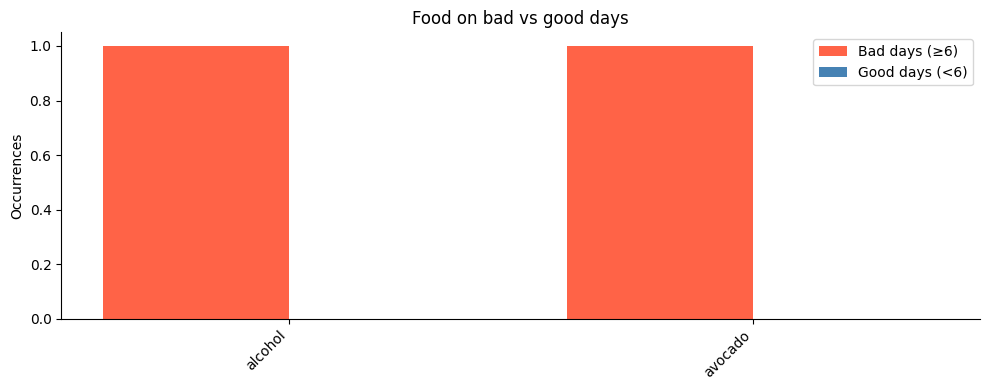

In [6]:
REDNESS_THRESHOLD = 6  # adjust as needed

food_on_bad_days = q(f"""
    WITH bad_days AS (
        SELECT date(timestamp) AS day
        FROM events
        WHERE tag = 'symptom'
          AND category = 'face_redness'
          AND CAST(value AS INTEGER) >= {REDNESS_THRESHOLD}
    )
    SELECT
        e.value                AS food,
        e.category,
        COUNT(*)               AS bad_day_occurrences
    FROM events e
    JOIN bad_days b ON date(e.timestamp) = b.day
    WHERE e.tag = 'food'
    GROUP BY e.value, e.category
    ORDER BY bad_day_occurrences DESC
""")

food_on_good_days = q(f"""
    WITH good_days AS (
        SELECT date(timestamp) AS day
        FROM events
        WHERE tag = 'symptom'
          AND category = 'face_redness'
          AND CAST(value AS INTEGER) < {REDNESS_THRESHOLD}
    )
    SELECT
        e.value                AS food,
        e.category,
        COUNT(*)               AS good_day_occurrences
    FROM events e
    JOIN good_days g ON date(e.timestamp) = g.day
    WHERE e.tag = 'food'
    GROUP BY e.value, e.category
    ORDER BY good_day_occurrences DESC
""")

if food_on_bad_days.empty:
    print(f'No food events on high-redness days (threshold ≥ {REDNESS_THRESHOLD}).')
    print('Keep logging daily and this will populate.')
else:
    merged = food_on_bad_days.merge(food_on_good_days, on=['food', 'category'], how='outer').fillna(0)
    merged['bad_day_occurrences']  = merged['bad_day_occurrences'].astype(int)
    merged['good_day_occurrences'] = merged['good_day_occurrences'].astype(int)
    print(f'Food frequency on bad days (redness ≥ {REDNESS_THRESHOLD}):')
    display(merged.sort_values('bad_day_occurrences', ascending=False))

    fig, ax = plt.subplots(figsize=(10, 4))
    x = range(len(merged))
    ax.bar([i - 0.2 for i in x], merged['bad_day_occurrences'],  0.4, label=f'Bad days (≥{REDNESS_THRESHOLD})', color='tomato')
    ax.bar([i + 0.2 for i in x], merged['good_day_occurrences'], 0.4, label=f'Good days (<{REDNESS_THRESHOLD})', color='steelblue')
    ax.set_xticks(list(x))
    ax.set_xticklabels(merged['food'], rotation=45, ha='right')
    ax.set_ylabel('Occurrences')
    ax.set_title('Food on bad vs good days')
    ax.legend()
    plt.tight_layout()
    plt.show()

## 5. Correlation matrix (when enough data exists)

In [7]:
daily = q("""
    SELECT
        date(e.timestamp)                AS day,
        AVG(CASE WHEN e.tag='symptom' AND e.category='face_redness'
                 THEN CAST(e.value AS REAL) END) AS redness,
        AVG(CASE WHEN e.tag='stress'  THEN CAST(e.value AS REAL) END) AS self_stress,
        g.stress_avg                     AS garmin_stress,
        g.sleep_total_sec / 3600.0       AS sleep_h,
        g.rhr_avg,
        g.steps,
        SUM(CASE WHEN e.tag='food' AND e.category='junk' THEN 1 ELSE 0 END) AS junk_food_count
    FROM events e
    LEFT JOIN garmin_daily g ON date(e.timestamp) = g.day
    GROUP BY date(e.timestamp)
    ORDER BY day
""")

numeric = daily.drop(columns=['day']).apply(pd.to_numeric, errors='coerce')
corr = numeric.corr()

if corr['redness'].dropna().shape[0] < 2:
    print('Not enough data for correlation yet — keep logging for a few weeks.')
else:
    redness_corr = corr['redness'].drop('redness').sort_values(key=abs, ascending=False)
    print('Correlation with face redness:')
    print(redness_corr.to_string())

    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ['tomato' if v > 0 else 'steelblue' for v in redness_corr]
    redness_corr.plot.barh(ax=ax, color=colors)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel('Correlation coefficient')
    ax.set_title('What correlates with face redness?')
    plt.tight_layout()
    plt.show()

Not enough data for correlation yet — keep logging for a few weeks.
